## TRATAMIENTO DATASET

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14,9]

import collections
from PIL import Image

from fastai import *
from fastai.callbacks import *
from fastai.vision import *
from fastai.metrics import error_rate


import fastai
fastai.__version__

'1.0.54'

In [3]:
path = Path("IMÁGENES FILTRADAS/")

In [4]:
path.ls()

[PosixPath('IMÁGENES FILTRADAS/BURKITT_32.jpg'),
 PosixPath('IMÁGENES FILTRADAS/LLC_6.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_20.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_16.jpg'),
 PosixPath('IMÁGENES FILTRADAS/HCL_21.jpg'),
 PosixPath('IMÁGENES FILTRADAS/HCL_10.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_110.jpg'),
 PosixPath('IMÁGENES FILTRADAS/LLC_48.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_85.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_73.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_7.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_138.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_44.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_147.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_62.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_10.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_135.jpg'),
 PosixPath('IMÁGENES FILTRADAS/HCL_6.jpg'),
 PosixPath('IMÁGENES FILTRADAS/LCM_23.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_107.jpg'),
 PosixPath('IMÁGENES FILTRAD

In [5]:
fnames = get_image_files(path)
fnames[:10]

[PosixPath('IMÁGENES FILTRADAS/BURKITT_32.jpg'),
 PosixPath('IMÁGENES FILTRADAS/LLC_6.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_20.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_16.jpg'),
 PosixPath('IMÁGENES FILTRADAS/HCL_21.jpg'),
 PosixPath('IMÁGENES FILTRADAS/HCL_10.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_110.jpg'),
 PosixPath('IMÁGENES FILTRADAS/LLC_48.jpg'),
 PosixPath('IMÁGENES FILTRADAS/FOLICULAR_85.jpg'),
 PosixPath('IMÁGENES FILTRADAS/BURKITT_73.jpg')]

In [6]:
pat = r'/([^/]+)_\d+.jpg$'

In [7]:
data = ImageDataBunch.from_name_re(path, fnames, pat, ds_tfms=get_transforms(), size=363).normalize(imagenet_stats)

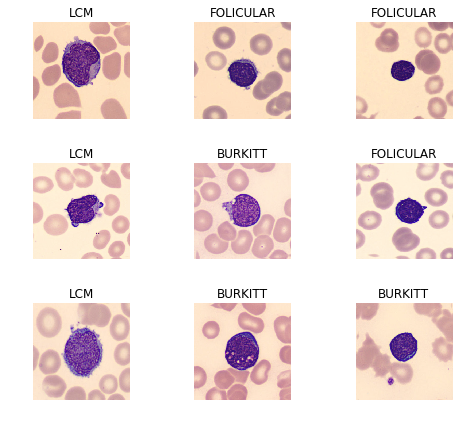

In [8]:
data.show_batch(rows=3, figsize=(7,6))

In [9]:
train = data.train_ds
valid = data.valid_ds

In [10]:
df= pd.concat([train.to_df(),valid.to_df()], ignore_index=False)
df.head()

,x,y
0,BURKITT_32.jpg,BURKITT
1,LLC_6.jpg,LLC
2,HCL_10.jpg,HCL
3,FOLICULAR_44.jpg,FOLICULAR
4,FOLICULAR_62.jpg,FOLICULAR


In [11]:
df.columns=['Image','Id']
df.head()

,Image,Id
0,BURKITT_32.jpg,BURKITT
1,LLC_6.jpg,LLC
2,HCL_10.jpg,HCL
3,FOLICULAR_44.jpg,FOLICULAR
4,FOLICULAR_62.jpg,FOLICULAR


In [12]:
print(data.classes)

['BURKITT', 'FOLICULAR', 'HCL', 'LCM', 'LLC']


In [13]:
len(data.classes),data.c

(5, 5)

In [14]:
df['Id'].value_counts()[:5]

BURKITT      188
FOLICULAR    149
LCM           59
LLC           57
HCL           48
Name: Id, dtype: int64

In [15]:
df['target'] = 1
df1 = df.copy()
df['target'] = 0
df = df.append(df1)
target_col = 2

In [16]:
df.head()

,Image,Id,target
0,BURKITT_32.jpg,BURKITT,0
1,LLC_6.jpg,LLC,0
2,HCL_10.jpg,HCL,0
3,FOLICULAR_44.jpg,FOLICULAR,0
4,FOLICULAR_62.jpg,FOLICULAR,0


In [17]:
df.shape

(1002, 3)

## ITEMBASE Y ITEMLIST

In [18]:
mean, std = torch.tensor(imagenet_stats)

class SiamImage(ItemBase):
    def __init__(self, img1, img2): 
        self.img1, self.img2 = img1, img2
        self.obj, self.data = (img1, img2), [(img1.data-mean[...,None,None])/std[...,None,None], (img2.data-mean[...,None,None])/std[...,None,None]]
    def apply_tfms(self, tfms,*args, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, *args, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, *args, **kwargs)
        self.data = [(self.img1.data-mean[...,None,None])/std[...,None,None], (self.img2.data-mean[...,None,None])/std[...,None,None]]
        return self
    def __repr__(self): return f'{self.__class__.__name__} {self.img1.shape, self.img2.shape}'
    def to_one(self):
        return Image(mean[...,None,None]+torch.cat(self.data,2)*std[...,None,None])

In [19]:
class SiamImageItemList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


    def __len__(self)->int: return len(self.items) or 1 

    def get(self, i):
        match=1
        if i>=len(self.items)//2:
            match = 0
        fn = self.items[i]
        img1 = super().get(i) 

        imgs = self.inner_df.Image.values
        ids = self.inner_df.Id.values
        wcls = ids[i]
        simgs = imgs[ids == wcls]
        dimgs = imgs[ids != wcls]
        if len(simgs)==1 and match==1:
            fn2=fn
        else:
            while True:
                np.random.shuffle(simgs)
                np.random.shuffle(dimgs)
                if simgs[0] != fn:
                    fn2 = [simgs[0] if match==1 else dimgs[0]][0]
                    break
            fn2 = self.items[np.where(imgs==fn2)[0][0]]
        img2 = super().open(fn2) 
        return SiamImage(img1, img2)

    def reconstruct(self, t): return SiamImage(mean[...,None,None]+t[0]*std[...,None,None], mean[...,None,None]+t[1]*std[...,None,None])

    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()
        

In [20]:
whl_tfms = get_transforms()
bs = 8

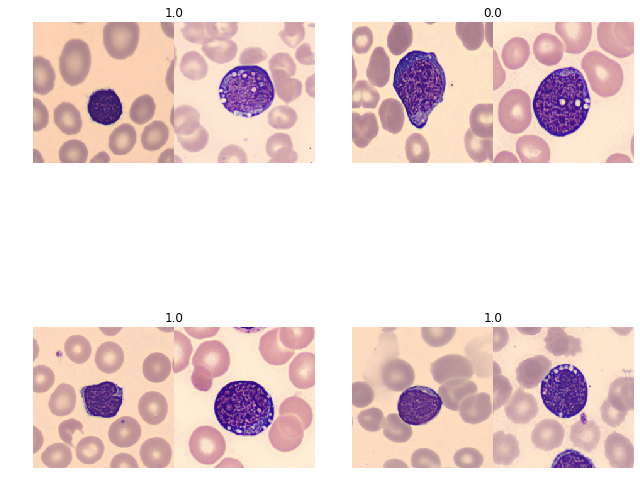

In [21]:
data = (SiamImageItemList.from_df(df=df, path=path, cols=0)
         .split_by_rand_pct(valid_pct=0.2, seed=34)
         .label_from_df(cols=target_col, label_cls=FloatList)
         .transform(whl_tfms, size=224)
         .databunch(bs=bs))

data.show_batch(2)

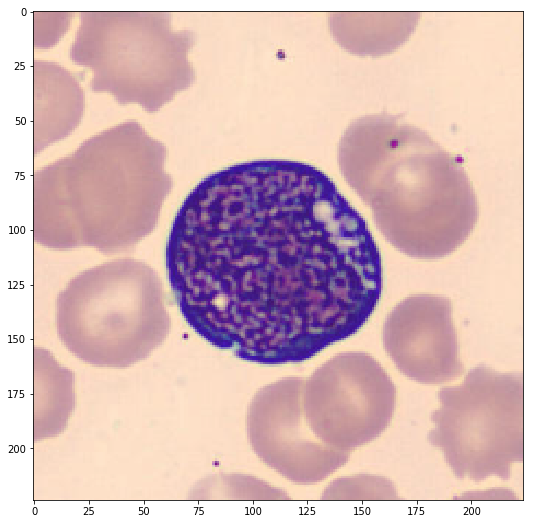

In [22]:
x = next(iter(data.train_dl))
t=x[0][0][0].cpu()
to = mean[...,None,None] + t* std[...,None,None]
import torchvision
ti = torchvision.transforms.ToPILImage(to)
plt.imshow(to.numpy().transpose(1,2,0))

## IMPORTAR DICCIONARIOS

In [23]:
import pickle
pickle_in = open("dict.pickle","rb")
pesos_dic = pickle.load(pickle_in)

In [24]:
pretrained_dict = pesos_dic
modelo = models.resnet34(pretrained=True)
model_dict = modelo.state_dict()

In [25]:
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict) 
modelo.load_state_dict(model_dict)

In [26]:
pesos_dic

OrderedDict([('0.0.weight',
              tensor([[[[ 5.4109e-03, -6.9092e-03,  7.8839e-03,  ...,  4.9072e-02,
                          3.0660e-02,  2.5398e-02],
                        [ 4.1081e-02,  3.1296e-02,  3.2265e-02,  ...,  3.3145e-02,
                          2.9754e-02,  4.1735e-02],
                        [ 4.9519e-03, -3.1705e-02, -6.1310e-02,  ..., -9.7493e-02,
                         -1.1601e-01, -1.2191e-01],
                        ...,
                        [-1.2287e-02, -2.4841e-02, -9.3052e-03,  ...,  1.7113e-02,
                          2.4631e-03,  1.6726e-02],
                        [ 3.9117e-03,  4.4537e-03,  3.6315e-02,  ...,  1.0371e-01,
                          7.3973e-02,  5.9085e-02],
                        [ 1.6784e-02,  8.8902e-03,  3.1312e-02,  ...,  9.6964e-02,
                          8.3749e-02,  9.6970e-02]],
              
                       [[-7.7192e-03, -8.7711e-03,  1.4143e-02,  ...,  3.3901e-02,
                          2.5483e-

## SNN Y LOSS FUNCTION

In [27]:
from fastai.vision import learner

class SiameseNet(nn.Module):
    def __init__(self, arch=models.resnet34, lin_ftrs=[256, 128], emb_sz=128,ps=0.5, bn_final=False):
        super(SiameseNet, self).__init__()
        self.arch, self.emb_sz = arch, emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        self.body = learner.create_body(self.arch, True, learner.cnn_config(self.arch)['cut'])
        model_dict = self.body.state_dict()
        pretrained_dict = pesos_dic
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict) 
        self.body.load_state_dict(model_dict)
        self.head = learner.create_head(num_features_model(self.body) * 1, self.emb_sz, self.lin_ftrs, self.ps,self.bn_final)
        self.cnn = nn.Sequential(self.body, self.head)

    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.cnn(x)

In [28]:
class ContrastiveLoss(nn.Module):

    def __init__(self, margin=5.):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, ops, target, size_average=True):
        op1, op2 = ops[0], ops[1]
        dist = F.pairwise_distance(op1, op2)
        pdist = dist*target
        ndist = dist*(1-target)
        loss = 0.5* ((pdist**2) + (F.relu(self.margin-ndist)**2))
        return loss.mean() if size_average else losses.sum()

## INSTANCIAR EL MODELO

In [30]:
model = SiameseNet().cuda()
apply_init(model.head, nn.init.kaiming_normal_)
loss_func=ContrastiveLoss().cuda()
siam_learner = Learner(data, model, loss_func=loss_func, model_dir=Path(os.getcwd()) ) 

In [36]:
siam_learner.fit_one_cycle(2)

epoch,train_loss,valid_loss,time
0,9.320746,10.367023,00:10
1,9.465702,10.761040,00:10


In [37]:
siam_learner.save('stage-1')

In [38]:
siam_learner.load('stage-1')

/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ContrastiveLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type SiameseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (802 items)
x: SiamImageItemList
SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))
y: FloatList
0.0,0.0,0.0,0.0,0.0
Path: IMÁGENES FILTRADAS;

Valid: LabelList (200 items)
x: SiamImageItemList
SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224])),SiamImage (torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))
y: FloatList
0.0,0.0,0.0,1.0,0.0
Path: IMÁGENES FILTRADAS;

Test: None, model=SiameseNet(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), strid

In [39]:
siam_learner.unfreeze()

In [41]:
siam_learner.fit_one_cycle(4, slice(1e-5))

epoch,train_loss,valid_loss,time
0,9.465879,10.880427,00:10
1,9.547116,11.007293,00:10
2,9.697095,11.020259,00:10
3,9.452457,10.977212,00:10


In [42]:
siam_learner.load('stage-1');

/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ContrastiveLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type SiameseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [43]:
siam_learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


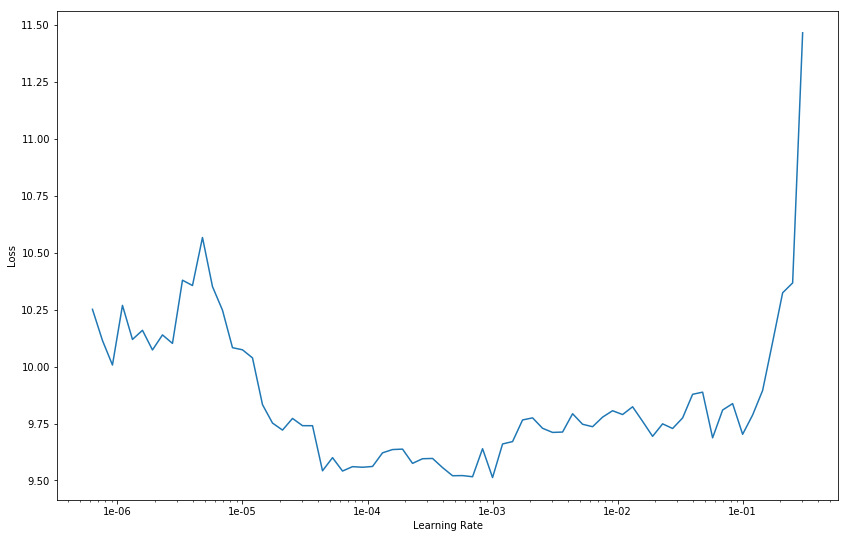

In [44]:
siam_learner.recorder.plot()

In [45]:
siam_learner.unfreeze()

In [46]:
siam_learner.fit_one_cycle(4, slice(1e-5))

epoch,train_loss,valid_loss,time
0,9.349730,10.920542,00:10
1,9.457721,10.928866,00:10
2,9.537915,10.996984,00:10
3,9.571998,10.970201,00:10


In [47]:
siam_learner.model

SiameseNet(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [48]:
siam_learner.save('stage-2')

In [49]:
def extract_embedding(dl, ds, mdl):
    mdl.eval()
    with torch.no_grad():
        preds = torch.zeros((len(ds), 128))
        start=0
        for cnt, (x, y) in enumerate(dl, start=0):
            size = x[0].shape[0]
            preds[start:start+size,:] = model.get_embedding(x[0])
            start+= size
        return preds

In [50]:
data = (SiamImageItemList.from_df(df=df, path=path, cols=0)
         .split_by_rand_pct(valid_pct=1, seed=34)
         .label_from_df(cols=target_col, label_cls=FloatList)
         .transform(whl_tfms, size=224)
         .databunch(bs=4))

/opt/conda/envs/fastai/lib/python3.6/site-packages/fastai/data_block.py:451: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


In [51]:
dl = data.valid_dl
ds = data.valid_ds
res = extract_embedding(dl, ds, model)

In [52]:
res.numpy().shape

(1002, 128)

In [53]:
whlc= np.array([df.loc[df.Image == Path(i.split(sep='/')[1]), 'Id'].values[0] for i in ds.items])

In [54]:
res.shape

torch.Size([1002, 128])

In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [56]:
pca.fit(res)
embs2d = pca.transform(res)

In [57]:
import colorsys
def random_colors(N, bright=True):
    
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def plot_embeddings(embeddings=None,whlc=None, xlim=None, ylim=None):

    plt.figure(figsize=(10,10))
    for cnt, i in enumerate(set(whlc)):

        inds = np.where(whlc==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[cnt])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(set(whlc))

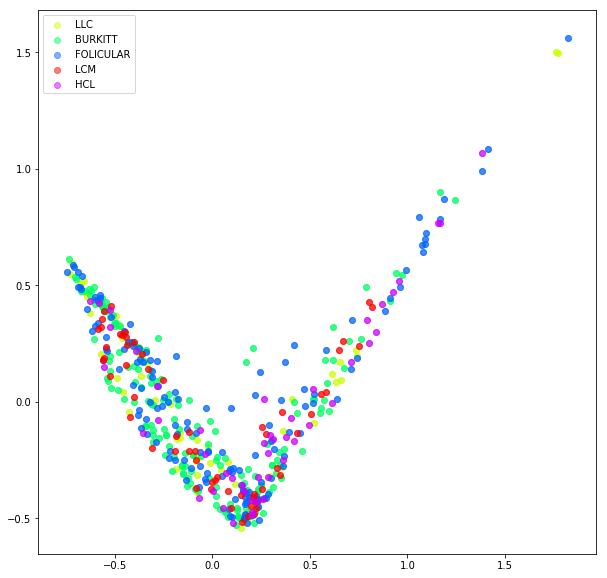

In [60]:
colors = random_colors(len(set(whlc)))
plot_embeddings(embs2d,whlc, xlim=None, ylim=None)

In [59]:
features = pd.DataFrame(res.numpy())
features['label'] = whlc
features.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,0.303570,0.127164,-0.050662,0.092682,-0.007337,0.149751,0.140774,-0.153999,-0.074662,0.138503,...,0.054768,0.237308,-0.177297,0.040262,-0.181552,0.002171,-0.074443,-0.135663,-0.067108,BURKITT
1,0.130836,-0.090437,0.031835,0.046471,-0.007684,0.099133,0.168100,-0.141251,-0.046982,0.152530,...,0.134864,-0.028236,0.022027,0.008069,-0.054835,0.106006,0.030845,0.134806,0.020873,LCM
2,-0.082438,-0.121079,0.092075,0.077915,-0.049757,0.070434,0.157969,-0.210783,-0.127968,-0.086563,...,0.112297,-0.056437,0.004910,0.019425,0.039268,0.072482,0.085632,0.063086,0.085250,HCL
3,0.199451,-0.107091,-0.015077,-0.062577,-0.033820,0.038226,0.136550,-0.146430,-0.037152,0.196536,...,0.115696,-0.068215,0.030790,0.037769,-0.085318,0.120852,0.010298,0.149509,-0.034799,FOLICULAR
4,0.175469,-0.097085,-0.017843,-0.058506,-0.035658,0.044973,0.149211,-0.136205,-0.024442,0.185044,...,0.109098,-0.023544,0.022116,0.042221,-0.088396,0.119350,0.008846,0.097733,-0.005446,LCM


In [61]:
features.shape

(1002, 129)

In [62]:
def oneshot(model,img1,img2):
    output1,output2 = model(img1.cuda(),img2.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    return euclidean_distance

In [63]:
df_original = df1.reset_index(drop=True)
df_original.head()

,Image,Id,target
0,BURKITT_32.jpg,BURKITT,1
1,LLC_6.jpg,LLC,1
2,HCL_10.jpg,HCL,1
3,FOLICULAR_44.jpg,FOLICULAR,1
4,FOLICULAR_62.jpg,FOLICULAR,1


In [64]:
df_original

,Image,Id,target
0,BURKITT_32.jpg,BURKITT,1
1,LLC_6.jpg,LLC,1
2,HCL_10.jpg,HCL,1
3,FOLICULAR_44.jpg,FOLICULAR,1
4,FOLICULAR_62.jpg,FOLICULAR,1
5,BURKITT_10.jpg,BURKITT,1
6,BURKITT_135.jpg,BURKITT,1
7,LCM_23.jpg,LCM,1
8,FOLICULAR_107.jpg,FOLICULAR,1
9,FOLICULAR_31.jpg,FOLICULAR,1


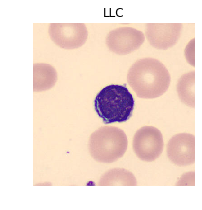

In [154]:
im1 = open_image( path / df_original.Image[499])
im1.show()
plt.title(df_original.Id[499])
plt.show()

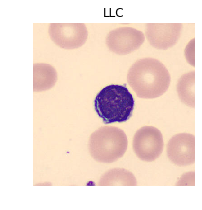

In [155]:
im2 = open_image( path / df_original.Image[499])
im2.show()
plt.title(df_original.Id[499])
plt.show()

In [156]:
oneshot(siam_learner.model, im1.resize(224).data[None,:,:,:], im2.resize(224).data[None,:,:,:])

tensor([1.1314e-05], device='cuda:0', grad_fn=<NormBackward1>)

In [68]:
def obtenervector(im1, im2, mdl):
    mdl.eval()
    with torch.no_grad():
        out1, out2 = mdl(im1,im2)
        return out1, out2

In [69]:
c=0
for cnt, (x, y) in enumerate(dl, start=0):
    c = c+1
    o1,o2 = model(x[0],x[1])
    v = x[0]
    if c == 1:
        break
   

In [70]:
oneshot(siam_learner.model, v[[2]], v[[1]])

tensor([0.6768], device='cuda:0', grad_fn=<NormBackward1>)

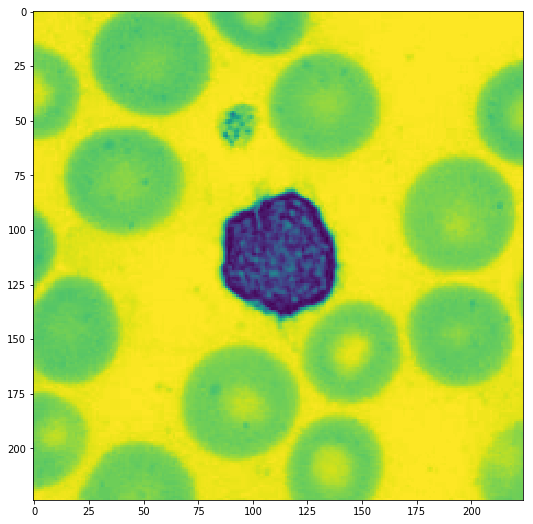

In [71]:
plt.imshow(v.cpu().numpy()[3][0])


In [72]:
oneshot(siam_learner.model, im1.resize(224).data[None,:,:,:], im2.resize(224).data[None,:,:,:])

tensor([0.0013], device='cuda:0', grad_fn=<NormBackward1>)

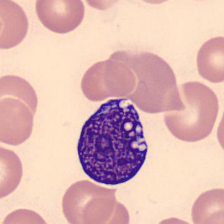

In [73]:
im1.resize(224)